<a href="https://colab.research.google.com/github/HikariJadeEmpire/Firewall_Classifier/blob/main/ML_Firewall.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import sys
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print( f"Python {sys.version}\nPandas {pd.__version__}\nNumPy {np.__version__}\n\
Matplotlib {mpl.__version__}\n" ) 

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
NumPy 1.23.5
Matplotlib 3.7.0



# Import DATA

In [2]:
# Import DATA

df = pd.read_csv( 'log2.csv' )
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


# Inspect & Clean DATA

In [4]:
df.iloc[:,:4] = df.iloc[:,:4].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  object
 1   Destination Port      65532 non-null  object
 2   NAT Source Port       65532 non-null  object
 3   NAT Destination Port  65532 non-null  object
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 6.0+ MB


In [5]:
df.nunique()

Source Port             22724
Destination Port         3273
NAT Source Port         29152
NAT Destination Port     2533
Action                      4
Bytes                   10724
Bytes Sent               6683
Bytes Received           8814
Packets                  1116
Elapsed Time (sec)        915
pkts_sent                 749
pkts_received             922
dtype: int64

In [6]:
df["Action"].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

In [7]:
action = df.groupby('Action').size().to_frame( 'count' )
action

,count
Action,
allow,37640
deny,14987
drop,12851
reset-both,54


(-1.55, 2.25)

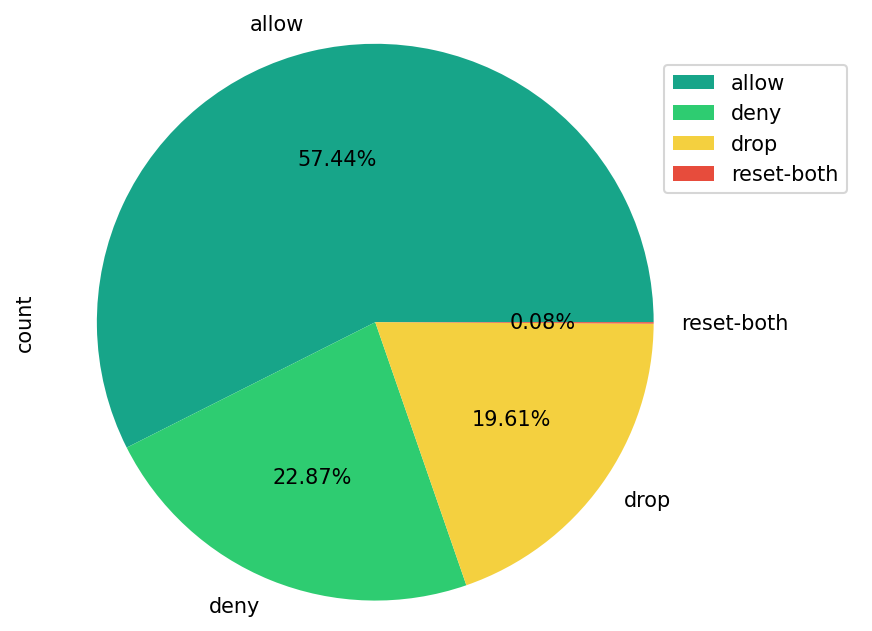

In [8]:
# Inspect 'Action' column

plt.figure(figsize=(7,7),dpi=150)
ax = plt.gca()
action.plot( kind='pie',
             y='count',       
             labels=action.index,  
             radius=1.3, 
             colors = [ '#17A589','#2ECC71','#F4D03F','#E74C3C' ],
             autopct='%0.2f%%',
             ax=ax
          )
left, right = ax.get_xlim()    
ax.set_xlim(left-0.3, right+1)

Text(0.5, 1.0, 'Correlation Heatmap')

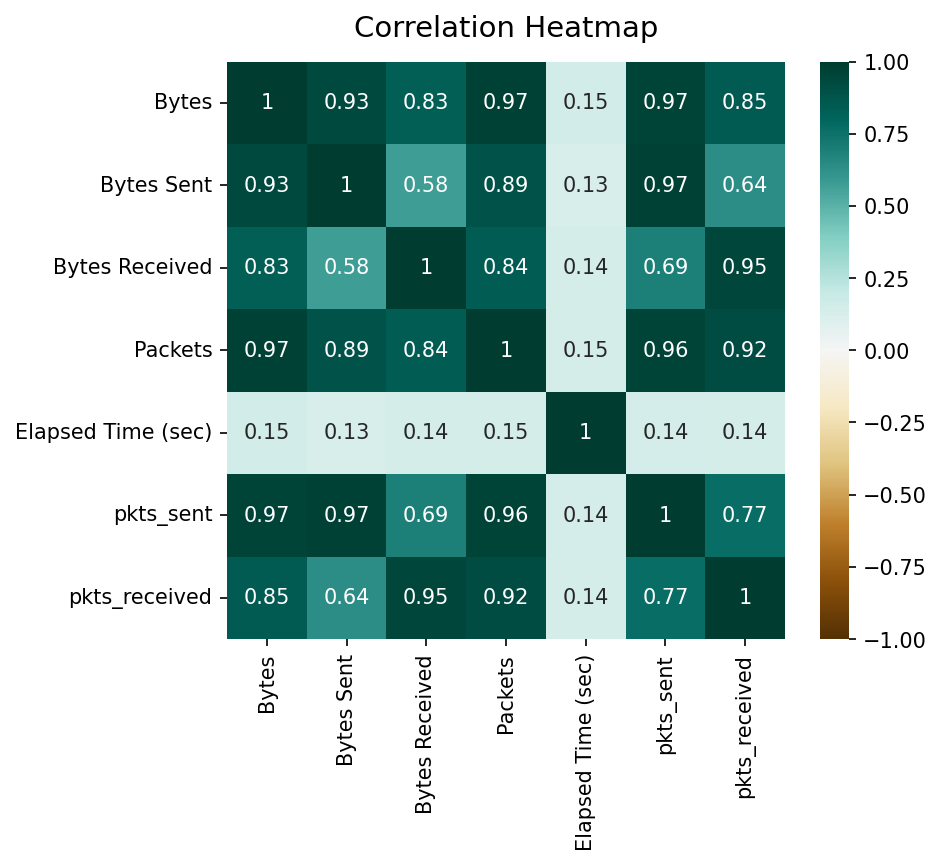

In [9]:
# Correlation Plot

plt.figure(figsize=(6, 5), dpi=150 )

heatmap = sns.heatmap(df.iloc[:,5:].corr(), vmin=-1, vmax=1, annot=True , cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

# Prepare X and Y

In [10]:
# Prepare X and Y

x = df.drop(columns=['Action'])
Y = df.loc[ :, ["Action"] ]

# Prepare X By Feature Scaling

x_fs = df.drop(columns=['Action'])
x_fs.iloc[ :,4: ] = x_fs.iloc[ :,4: ].apply( lambda x : ( x-x.min() )/( x.max()-x.min() ) )

In [11]:
# Binarize the output

from sklearn import preprocessing

y = preprocessing.label_binarize(Y, classes=['allow', 'deny', 'drop', 'reset-both'])
n_classes = y.shape[1]


In [12]:
print(y)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]


- class 0 : 'allow'
- class 1 : 'deny'
- class 2 : 'drop'
- class 3 : 'reset-both'

# Train

Decision Tree

In [13]:
# Split By Cross Validation Method (Before train & test Split)
# try on Decision Tree

from sklearn import tree
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score

clf = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 42)

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, x, y, cv = k_folds)

print("Cross Validation Scores : ", scores)
print("Average CV Score : ", scores.mean())
print("Number of CV Scores used in Average : ", len(scores))

Cross Validation Scores :  [0.99740597 0.99740597 0.99786357 0.99694796 0.99771097]
Average CV Score :  0.9974668882659461
Number of CV Scores used in Average :  5


K Nearest Neighbors

In [14]:
# try on KNN

from sklearn.neighbors import KNeighborsClassifier

for i in range(1,6) :
    knn = KNeighborsClassifier( n_neighbors = i )

    scores_1 = cross_val_score(knn, x_fs, y, cv = k_folds)

    print(f"KNN CV TEST at n_neighbors : {i}")
    print("Cross Validation Scores : ", scores_1)
    print("Average CV Score : ", scores_1.mean())
    print("Number of CV Scores used in Average : ", len(scores_1) ,'\n')

KNN CV TEST at n_neighbors : 1
Cross Validation Scores :  [0.99259937 0.99015793 0.99076759 0.98908897 0.98763925]
Average CV Score :  0.990050621741107
Number of CV Scores used in Average :  5 

KNN CV TEST at n_neighbors : 2
Cross Validation Scores :  [0.98794537 0.98687724 0.98588433 0.98237448 0.98252709]
Average CV Score :  0.9851217026916853
Number of CV Scores used in Average :  5 

KNN CV TEST at n_neighbors : 3
Cross Validation Scores :  [0.99420157 0.99351492 0.992141   0.99076759 0.99000458]
Average CV Score :  0.9921259313827655
Number of CV Scores used in Average :  5 

KNN CV TEST at n_neighbors : 4
Cross Validation Scores :  [0.99160754 0.99092088 0.99099649 0.98718144 0.98702884]
Average CV Score :  0.9895470390901888
Number of CV Scores used in Average :  5 

KNN CV TEST at n_neighbors : 5
Cross Validation Scores :  [0.99412528 0.99320974 0.99282771 0.99008088 0.99046238]
Average CV Score :  0.9921411973903277
Number of CV Scores used in Average :  5 



We have decided to select the Decision tree model

In [15]:
# Train & Test Split

X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.20, random_state = 42 )

# Cross Validate

cv_results = cross_validate(clf, X_train, y_train, cv = k_folds, return_estimator = True)

print(f"Cross Validation Scores : { cv_results['test_score'] }")
print(f"Average CV Score : { cv_results['test_score'].mean() }")
print("Number of CV Scores used in Average : ", len(cv_results['test_score']) )

Cross Validation Scores : [0.99685265 0.99799714 0.99752027 0.99713877 0.99752027]
Average CV Score : 0.9974058178350024
Number of CV Scores used in Average :  5


# TEST

In [16]:
# Finding the best Maximum Depth

from sklearn.metrics import f1_score

score = []
for i in range(1,16):
    classifier = tree.DecisionTreeClassifier( criterion = 'gini', max_depth = i , random_state = 42 )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    score.append(f1_score(y_test, y_pred, average = 'macro'))

depth = {}
for i,j in enumerate(score) :
    if j == max(score) :
        depth[i] = j
        print(f" Depth = {i+1} : F1 Score = {j}")


 Depth = 8 : F1 Score = 0.9762997369548366


C:\Users\rastu\AppData\Local\Temp\ipykernel_8620\2522918548.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0.5, 1.0, 'F1 score from Dicision Tree model')

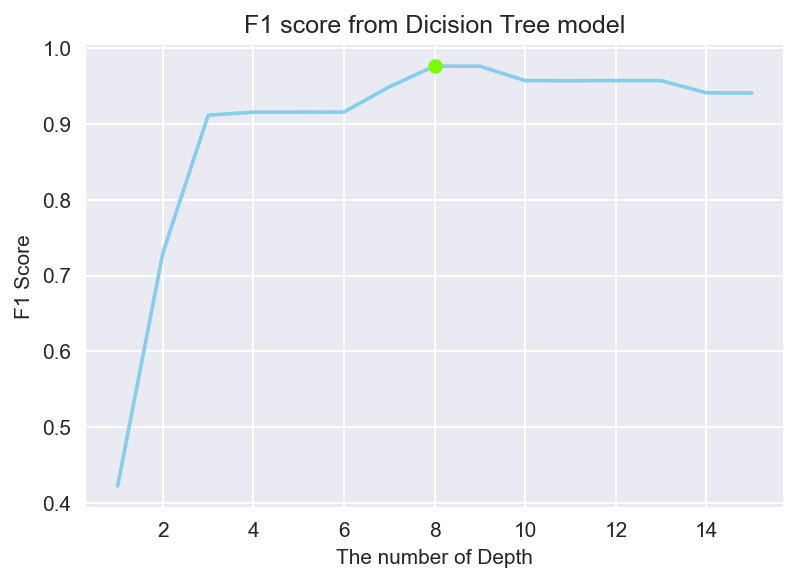

In [17]:
# plot

plt.figure( figsize = (6,4) , dpi=150 )

plt.style.use("seaborn")
plt.plot(range(1,16),score ,ls = 'solid', color = '#87CEEB')
plt.plot(min(depth)+1,min(depth.values()),marker = 'o',color = '#7CFC00' )
plt.xlabel("The number of Depth")                  
plt.ylabel("F1 Score")
plt.title( "F1 score from Dicision Tree model" )

In [18]:
# Predict y

classifier = tree.DecisionTreeClassifier( criterion = 'gini', max_depth = min(depth)+1 )
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(f" F1 Score : {f1_score(y_test, y_pred, average = 'macro')} ")

 F1 Score : 0.9762997369548366 


# Result

In [19]:
from sklearn.metrics import classification_report 
 
print(classification_report(y_test, y_pred)) 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       1.00      0.83      0.91         6

   micro avg       1.00      1.00      1.00     13107
   macro avg       1.00      0.96      0.98     13107
weighted avg       1.00      1.00      1.00     13107
 samples avg       1.00      1.00      1.00     13107



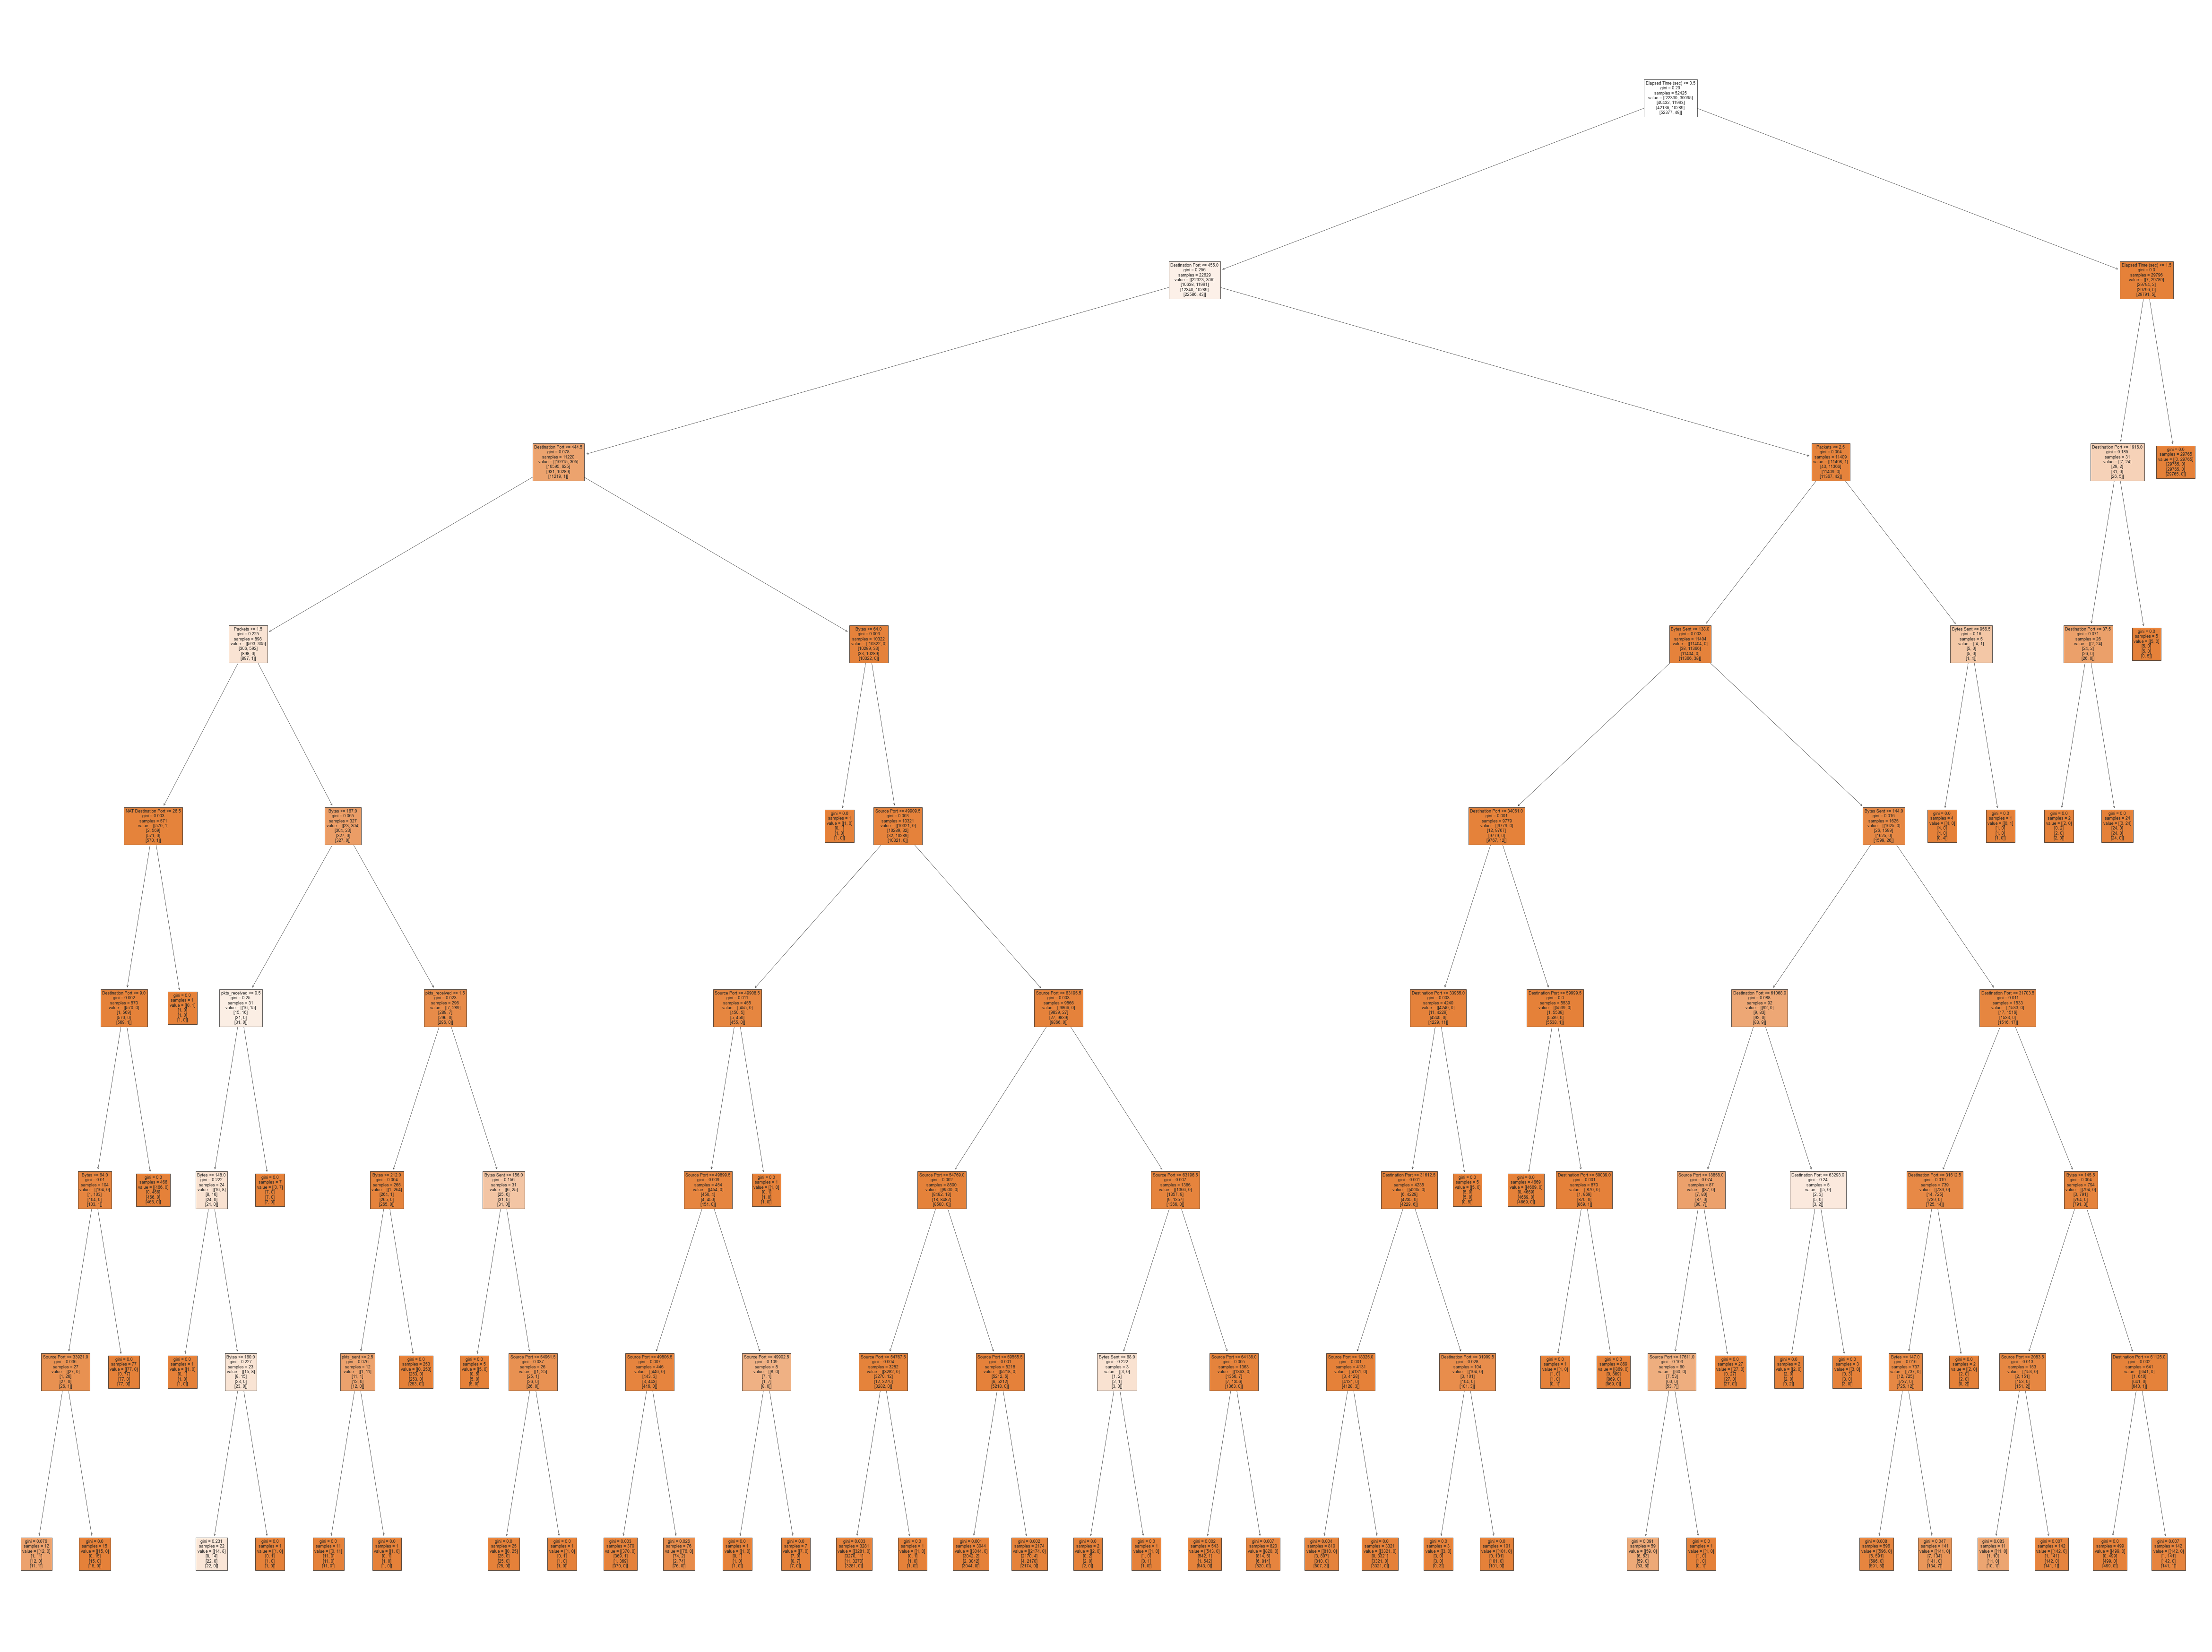

In [20]:
fig = plt.figure(figsize=(40,30),dpi=150)
_ = tree.plot_tree(classifier, 
                   feature_names=x.columns,  
                   class_names=Y.columns,
                   filled=True)

# ROC Curve
- class 0 : allow
- class 1 : deny
- class 2 : drop
- class 3 : reset-both

In [21]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [22]:
# Compute micro-average ROC curve and ROC area

fpr["macro"], tpr["macro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [23]:
colour = [ '#CD5C5C','#008B8B','#00FF7F','#BDB76B' ]

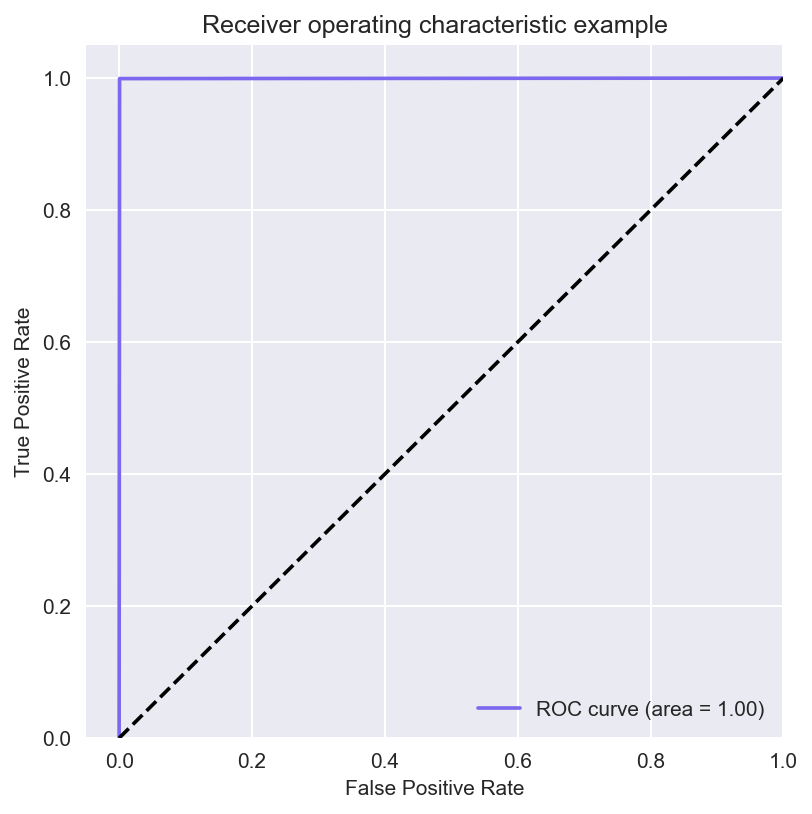

In [24]:
# Plot of a ROC curve for a specific class

plt.figure( figsize = (6,6) , dpi=150 )
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2], color = '#7B68EE' )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

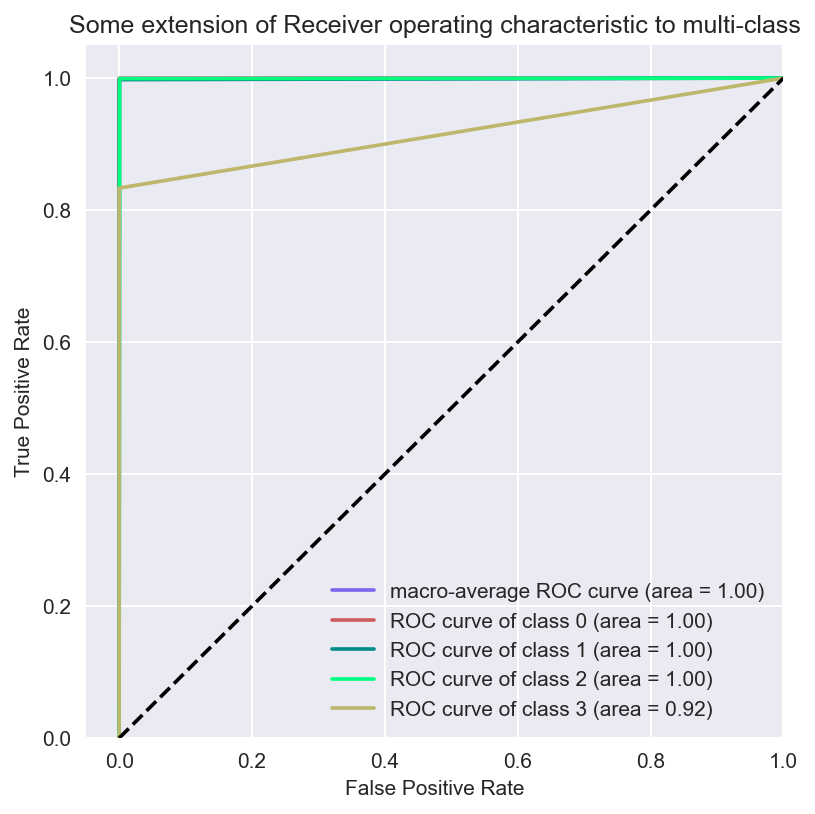

In [25]:
# Plot ROC curve

plt.figure( figsize = (6,6) , dpi=150 )
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]) , color = '#7B68EE' )
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]), color = colour[i] )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

- class 0 : 'allow'
- class 1 : 'deny'
- class 2 : 'drop'
- class 3 : 'reset-both'